In [1]:
%reset -f

import numpy as np
from scipy import special
import matplotlib.pyplot as plt

In [2]:
#    ====================| IRxx |==========================
def IRXX(sig, freq_m, T, Ts):
  tal = np.linspace(0, T, (int)(T/Ts) + 1)
  irxx = []
  for t_i in tal:
    irxx.append((sig**2) * special.jv(0, 2*np.pi*freq_m*t_i, out=None) )

  return np.array(irxx)


#    ====================|  Rxx  |=========================
def RXX(mod, freq, T, Ts, N = 10):
  rxx = []
  tal = np.linspace(0, T, (int)(T/Ts) + 1)
  for t_i in tal:
    temp = 0
    for n in range(N):
      temp += np.cos(2*np.pi*freq[n]*t_i)*(mod[n]**2)/2
    rxx.append(temp)
  return np.array(rxx)


#    ====================| NRxx |==========================
# τmax = Ni /(2 * fmax )
def NRxx(SoC, T, Ts):
  n = (int)(T/Ts) + 1
  rxx = []
  for k in range(n):
    temp = 0
    for i in range(k, n):             #Sobreposição das series
      temp += SoC[i-k]*np.conj(SoC[i])
    rxx.append(temp)#/(2*n))
  return np.array(rxx)


#     ====================|  Phas |========================
def Rand_PHAS(N):
  phas = np.random.default_rng().uniform(0,2 * np.pi, N)
  return phas


#    ======================| MEDS |========================
def EMEDS(sig, freq_m, N = 10):
  mod = []
  freq = []
  for i in range(1, N+1):
    mod.append(sig * (2 / N)**0.5)
    freq.append(freq_m * np.cos((2 * np.pi/ N) * (i - 0.25) ))
  return np.array(mod), np.array(freq)


#    ======================| GMEA |=======================
def GMEA(sig, F, N):
  #   JAKES
  mod = np.ones(N)* sig * (2 / N)**0.5
  freq = F*np.sin((np.arange(1, N+1))*np.pi/(2*N))
  return mod, freq


#     ====================|  SoC  |========================
def SoC(mod, freq, T, Ts, N = 10):
  phas = Rand_PHAS(N)
  t = np.linspace(0, T, (int)(T/Ts) + 1)
  soc = []

  for t_i in t:
    temp = 0
    for i in range(N):
      temp += complex(mod[i], 0) * np.exp(complex(0, 2 * np.pi * freq[i] * t_i + phas[i]))
    soc.append(temp)
  return np.array(soc)

In [3]:
#    |==================||PYTHON||=======================|
# Geração realizada pelo python

F = 91 # hz
sig = 1 
N = 21

tal = N/(4*F)
T = 10*tal
Ts = 0.0005

t_g = np.linspace(0, T, (int)(T/Ts) + 1)

#    |============| |CORRELAÇÃO IDEAL| |=================|
irxx = IRXX(sig, F, T, Ts)            # JAKES

#    |==================| |MEDS| |=======================|
mod, freq = EMEDS(sig, F, N)
rxx_meds = RXX(mod, freq, T, Ts, N)       #MEDS
#soc_meds = SoC(mod, freq, T, Ts, N)
#rxx_meds_n = NRxx(soc_meds, T, Ts)

rxx_meds_n = 0

for i in range(10):
  soc_meds = SoC(mod, freq, T, Ts, N)
  rxx_meds_n += NRxx(soc_meds, T, Ts)

rxx_meds_n /= 10

#    |==================| |GMEA| |=======================|
mod, freq = GMEA(sig, F, N)
rxx_gmea = RXX(mod, freq, T, Ts, N)       #MEDS
#soc_meds = SoC(mod, freq, T, Ts, N)
#rxx_meds_n = NRxx(soc_meds, T, Ts)

rxx_gmea_n = 0

for i in range(10):
  soc_gmea = SoC(mod, freq, T, Ts, N)
  rxx_gmea_n += NRxx(soc_gmea, T, Ts)

rxx_gmea_n /= 10


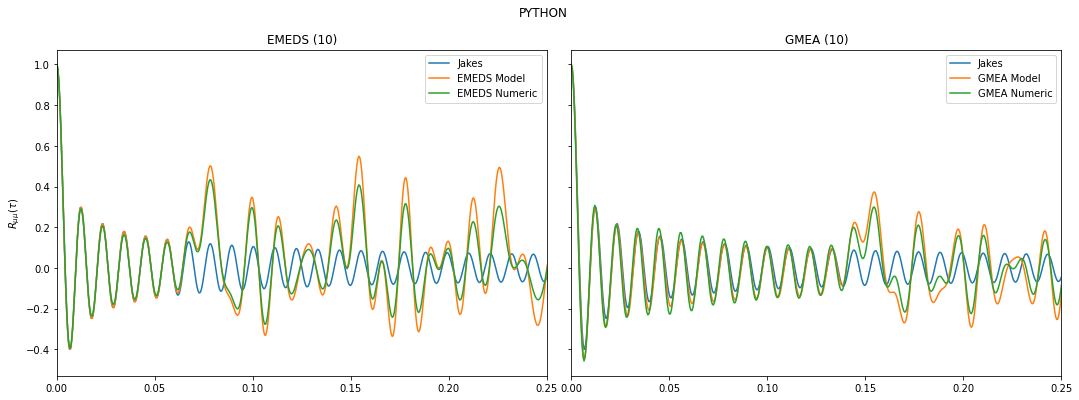

In [15]:
#    |==================| |PLOT| |=======================|
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (18, 6))
fig.suptitle('PYTHON')
ax1.plot(t_g, irxx, t_g, rxx_meds, t_g, np.real(rxx_meds_n)/np.real(rxx_meds_n[0]))
ax1.set_title('EMEDS (10)')
ax1.set_ylabel(r'$R_{\mu\mu}(\tau)$')
ax1.legend(['Jakes', 'EMEDS Model', 'EMEDS Numeric'])
ax1.set_xlim(0, 0.25)
ax2.plot(t_g, irxx, t_g, rxx_gmea, t_g, np.real(rxx_gmea_n)/np.real(rxx_gmea_n[0]))
ax2.set_title('GMEA (10)')
ax2.legend(['Jakes', 'GMEA Model', 'GMEA Numeric'])
ax2.set_xlim(0, 0.25)
fig.subplots_adjust(wspace=0.05)
fig.show()

In [5]:
#    |=================|  |CPP|  |=======================|
# Geração realizada pelo python

#    |==================| |MEDS| |=======================|
rxx_meds_cpp = np.array([1,0.978559,0.917565,0.820775,0.694094,0.545164,0.382858,0.216681,0.0561377,-0.0898843,-0.21369,-0.309258,-0.372596,-0.401952,-0.397872,-0.363087,-0.302258,-0.221594,-0.128366,-0.0303584,0.0646919,0.149648,0.218459,0.26656,0.291143,0.291302,0.268029,0.224067,0.163649,0.092116,0.0154844,-0.0600424,-0.128552,-0.184868,-0.224928,-0.246063,-0.247165,-0.228728,-0.192768,-0.142621,-0.0826519,-0.0178832,0.0464116,0.10513,0.153735,0.188601,0.207275,0.208649,0.193007,0.161986,0.118404,0.0660247,0.00923034,-0.047332,-0.099126,-0.142083,-0.172916,-0.189366,-0.190363,-0.176086,-0.147932,-0.108377,-0.0607649,-0.00902489,0.0426512,0.0901471,0.129748,0.15843,0.174089,0.175697,0.16336,0.138299,0.102732,0.0596783,0.0127121,-0.0343366,-0.0776896,-0.113922,-0.140229,-0.154645,-0.156184,-0.144907,-0.121901,-0.0891784,-0.0495031,-0.0061578,0.0373251,0.0774502,0.111038,0.135477,0.148924,0.150441,0.140061,0.118771,0.0884207,0.051565,0.0112469,-0.0292508,-0.0666725,-0.0980512,-0.120943,-0.133618,-0.135188,-0.125674,-0.105986,-0.0778449,-0.0436335,-0.00619612,0.0313948,0.0660891,0.0951041,0.116147,0.127592,0.128611,0.119225,0.100301,0.0734704,0.0409955,0.00558016,-0.0298491,-0.0623786,-0.0893388,-0.108514,-0.118313,-0.117887,-0.10719,-0.0869652,-0.0586807,-0.0243968,0.0134079,0.0520431,0.0888284,0.121311,0.147466,0.165851,0.175726,0.1771,0.170727,0.158036,0.141007,0.122005,0.10358,0.0882534,0.0783118,0.0756116,0.0814257,0.0963329,0.120164,0.152007,0.190268,0.23279,0.277011,0.320152,0.359423,0.392226,0.416342,0.430086,0.432425,0.423031,0.402298,0.371288,0.33164,0.285429,0.235005,0.18281,0.131195,0.0822608,0.0377135,-0.00123226,-0.0339091,-0.0602025,-0.0805091,-0.0956516,-0.10676,-0.115128,-0.122062,-0.128731,-0.136032,-0.144493,-0.154202,-0.164792,-0.175462,-0.18505,-0.19214,-0.195203,-0.19275,-0.183494,-0.166499,-0.141312,-0.108048,-0.067444,-0.0208563,0.0297912,0.082108,0.133379,0.180741,0.221373,0.252701,0.272582,0.279474,0.272557,0.251821,0.218081,0.172958,0.118779,0.0584515,-0.00472223,-0.0672468,-0.125655,-0.176724,-0.217682,-0.246373,-0.26139,-0.262155,-0.248936,-0.222821,-0.185627,-0.139772,-0.0881072,-0.0337238,0.020244,0.0708165,0.115346,0.151666,0.178203,0.19404,0.198939,0.193314,0.178163,0.154966,0.12556,0.0919926,0.0563818,0.0207753,-0.0129703,-0.043286,-0.0689585,-0.0891657,-0.103481,-0.111848,-0.114533,-0.112057,-0.105124,-0.0945397,-0.0811394,-0.0657286,-0.0490361,-0.0316873,-0.0141947,0.00303265,0.0196683,0.035437,0.0500807,0.063327,0.0748652,0.084335,0.0913288,0.0954117,0.0961548,0.0931821,0.0862238,0.0751723,0.0601334,0.0414662,0.0198064,-0.00393309,-0.0285848,-0.0527764,-0.0750029,-0.0937202,-0.107451,-0.114898,-0.115054,-0.107297,-0.0914694,-0.0679232,-0.0375319,-0.00166385,0.0378826,0.0789811,0.119309,0.156503,0.188322,0.212812,0.228463,0.234327,0.230115,0.216239,0.193813,0.16459,0.130866,0.0953291,0.0608767,0.030416,0.00665217,-0.00811321,-0.0121609,-0.0044963,0.0150573,0.0458209,0.0862835,0.134185,0.186655,0.240399,0.291918,0.337744,0.374687,0.400051,0.411834,0.408871,0.390926,0.358714,0.31386,0.258795,0.196588,0.130736,0.0649276,0.00278324,-0.0523928,-0.0978404,-0.131531,-0.152305,-0.15994,-0.155156,-0.139551,-0.115469,-0.0858183,-0.0538443,-0.0228811,0.00390443,0.0237559,0.0345386,0.0349055,0.0244025,0.00350854,-0.0263959,-0.0631275,-0.103859,-0.145331,-0.184089,-0.216749,-0.240249,-0.252087,-0.250513,-0.234673,-0.20469,-0.161671,-0.107643,-0.0454335,0.0215231,0.0894069,0.154271,0.212304,0.26009,0.294831,0.314532,0.318135,0.305575,0.27778,0.236597,0.184658,0.125196,0.0618225,-0.0017185,-0.0617964,-0.115129,-0.158987,-0.191354,-0.211036,-0.217705,-0.211886,-0.194882,-0.168649,-0.135627,-0.098542,-0.0602026,-0.0232887,0.00983397,0.0372715,0.0577162,0.0705125,0.0756695,0.0738217,0.0661424,0.0542179,0.0398933,0.025103,0.0116991,0.00129247,-0.00488265,-0.00606884,-0.00204406,0.0068658,0.0198207,0.0355431,0.0524307,0.0686969,0.0825255,0.09223,0.0964018,0.0940384,0.0846388,0.0682616,0.0455377,0.0176397,-0.013792,-0.0467598,-0.0790488,-0.108385,-0.132599,-0.149787,-0.158455,-0.157629,-0.146937,-0.126646,-0.0976526,-0.0614346,-0.0199563,0.0244561,0.0692653,0.111889,0.149867,0.181023,0.203605,0.216397,0.218795,0.210845,0.193234,0.167241,0.134655,0.097653,0.0586633,0.0202095,-0.0152462,-0.0454529,-0.0685051,-0.0829516,-0.0878737,-0.0829283,-0.0683545,-0.0449444,-0.0139803,0.0228545,0.063587,0.106079,0.148156,0.187733,0.22293,0.252171,0.274257,0.288417,0.294327,0.292106,0.282285,0.265749,0.243672,0.217425,0.188495,0.158387,0.128543,0.100264,0.0746461,0.0525387,0.0345116,0.0208465,0.0115433,0.0063427,0.00476127,0.00613669,0.00967941,0.0145273,0.0198003,0.0246513,0.0283121,0.0301308,0.0296014,0.0263823,0.020307,0.0113836,-0.000212758,-0.0141551,-0.0299863,-0.0471442,-0.0649906,-0.0828413,-0.0999964,-0.11577,-0.129516,-0.140658,-0.148701,-0.153261,-0.154067,-0.150977,-0.143979,-0.133192,-0.118861,-0.101348,-0.0811191,-0.0587304,-0.0348071,-0.0100238,0.0149176,0.0393113,0.06247,0.0837473,0.102557,0.118393,0.13084,0.139592,0.144453,0.145346,0.142313,0.135509,0.125199,0.111745,0.0955963,0.077274,0.057355,0.0364543,0.0152073,-0.00574892,-0.0257948,-0.044346,-0.0608714,-0.0749091,-0.0860817,-0.0941092,-0.0988187,-0.100152,-0.0981699,-0.0930494,-0.0850809,-0.0746578,-0.0622613,-0.0484418,-0.0337959,-0.0189394,-0.00447923,0.00901632,0.0210459,0.0312015,0.0391897,0.0448483,0.0481545,0.0492254,0.0483097,0.0457706,0.0420598,0.0376863,0.033178,0.0290426,0.0257277,0.0235837,0.022833,0.0235481,0.0256396,0.0288571,0.0328031,0.0369596,0.0407256,0.0434652,0.0445611,0.0434704,0.0397798,0.0332536,0.0238727,0.0118585,-0.0023187,-0.0179506,-0.0341205,-0.0497514,-0.0636694,-0.0746797,-0.0816502,-0.0835965,-0.079763,-0.0696938,-0.0532872,-0.0308297,-0.0030045,0.0291252,0.0641614,0.100441,0.136126,0.169313,0.198154,0.220969,0.236369,0.243349,0.241375,0.230429,0.21103,0.184222,0.151521,0.114835,0.0763497,0.0384019,0.00333063,-0.0266696,-0.0496923,-0.0642453,-0.0693533,-0.0646283,-0.0503022,-0.0272204,0.00320562,0.039083,0.0781542,0.117939,0.155892,0.189565,0.216764,0.235687,0.245044,0.244131,0.232876,0.211838,0.182162,0.145501,0.103902,0.0596662,0.0151919,-0.0271797,-0.0653196,-0.0974455,-0.12223,-0.138877,-0.147157,-0.147402,-0.140465,-0.127636,-0.110537,-0.0909863,-0.0708606,-0.0519502,-0.0358263,-0.023728,-0.0164761,-0.0144217,-0.017431,-0.0249089,-0.0358572,-0.0489641,-0.062717,-0.0755298,-0.0858747,-0.0924088,-0.0940847,-0.0902378,-0.0806426,-0.0655347,-0.0455966,-0.0219075,0.00413674,0.0309296,0.0567759,0.080021,0.0991772,0.113038,0.12077,0.121978,0.116733,0.105569,0.0894437,0.0696603,0.0477722,0.0254621,0.00441317,-0.0138197,-0.0279298,-0.0369586,-0.0403695,-0.0380897,-0.0305156,-0.0184823,-0.00319963,0.0138415,0.0309851,0.0465388,0.0589072,0.0667184,0.0689352,0.0649411,0.0545964,0.0382588,0.0167668,-0.00861283,-0.0362691,-0.0643578,-0.0909305,-0.114072,-0.132038,-0.14338,-0.147049,-0.14248,-0.129631,-0.108992,-0.0815627,-0.0487837,-0.0124465,0.0254234,0.0626983,0.0972859,0.127263,0.150998,0.167249,0.17524,0.1747,0.165871,0.14948,0.126682,0.0989773,0.068104,0.035923,0.00429734,-0.0250243,-0.0505118,-0.0709388,-0.0854441,-0.0935664,-0.0952498,-0.0908232,-0.0809541,-0.0665828,-0.0488422,-0.028969,-0.00821512,0.0122377,0.0313507,0.0482859,0.0624454,0.0734894,0.081335,0.0861346,0.0882398,0.0881522,0.0864677,0.0838174,0.0808119,0.0779916,0.075788,0.0744961,0.074263,0.0750883,0.0768384,0.0792713,0.0820684,0.0848718,0.0873209,0.0890876,0.089905,0.0895886,0.0880487,0.0852921,0.0814153,0.0765893,0.0710388,0.0650175,0.0587824,0.0525703,0.0465776,0.0409466,0.0357579,0.0310313,0.0267323,0.0227851,0.0190901,0.0155421,0.01205,0.00855217,0.00502901,0.0015084,-0.00193498,-0.00518744,-0.00811007,-0.0105575,-0.0123995,-0.0135432,-0.0139534,-0.0136681,-0.0128081,-0.0115781,-0.0102586,-0.00918958,-0.00874469,-0.00930011,-0.0111987,-0.0147131,-0.0200109,-0.0271256,-0.0359358,-0.0461552,-0.0573357,-0.068884,-0.0800909,-0.0901726,-0.0983216,-0.103762,-0.10581,-0.103925,-0.0977649,-0.0872174,-0.0724278,-0.0538043,-0.0320068,-0.00791819,0.0174016,0.0427749,0.0669758,0.0888052,0.107166,0.121133,0.130015,0.133397,0.131172,0.12355,0.11104,0.094422,0.0746966,0.0530184,0.0306223,0.00874457,-0.011456,-0.0289699,-0.0429973,-0.0529939,-0.0586972,-0.0601334,-0.0576043,-0.051655,-0.0430258,-0.032592,-0.0212955,-0.0100751,0.000201436,0.00879682,0.0151521,0.0189192,0.0199764,0.0184264,0.0145764,0.00890458,0.00201397,-0.00542124,-0.0127125,-0.0192126,-0.0243652,-0.0277454,-0.0290875,-0.0282985,-0.0254568,-0.0207972,-0.0146826,-0.00756715,4.74971e-05,0.00765732,0.0147996,0.0210905,0.0262542,0.0301405,0.0327301,0.0341273,0.0345406,0.0342547,0.0335946,0.0328872,0.0324232,0.0324229,0.0330097,0.0341939,0.0358679,0.0378144,0.0397258,0.0412351,0.0419532,0.0415119,0.0396065,0.0360354,0.0307323,0.0237877,0.0154579,0.00615877,-0.00355418,-0.0130201,-0.0215178,-0.0283191,-0.0327462,-0.0342279,-0.0323514,-0.0269039,-0.0179012,-0.00560002,0.00950718,0.0267154,0.0451468,0.0638047,0.0816379,0.0976111,0.110776,0.120336,0.125706,0.126552,0.122818,0.114732,0.102789,0.0877218,0.0704449,0.0519942,0.0334533,0.0158776,0.000221333,-0.0127283,-0.0224033,-0.0284908,-0.0309496,-0.0300062,-0.0261303,-0.0199927,-0.0124081,-0.00426813,0.00353145,0.0101619,0.0149269,0.0173164,0.0170446,0.0140701,0.00859551,0.00104717,-0.00796285,-0.0176901,-0.0273216,-0.0360454,-0.0431196,-0.0479357,-0.0500716,-0.0493281,-0.0457482,-0.039616,-0.0314353,-0.0218902,-0.0117903,-0.0020046,0.00660995,0.0132804,0.0173836,0.0185012,0.0164584,0.0113446,0.00351235,-0.00644454,-0.0177324,-0.0294157,-0.0404881,-0.0499489,-0.0568824,-0.0605308,-0.0603566,-0.0560894,-0.0477532,-0.0356713,-0.0204489,-0.00293474,0.0158371,0.0347187,0.0525301,0.0681435,0.0805649,0.0890057,0.0929405,0.0921451,0.0867132,0.0770487,0.0638369,0.0479938,0.0305992,0.0128177,-0.00418524,-0.0193281,-0.0316902,-0.0405768,-0.0455663,-0.0465366,-0.0436698,-0.0374323,-0.0285351,-0.0178752,-0.00646342,0.00465542,0.0144846,0.0221529,0.0269823,0.0285398,0.02667,0.0215066,0.013461,0.00318927,-0.00845919,-0.0205083,-0.0319315,-0.0417321,-0.049021,-0.0530871,-0.0534529,-0.0499142,-0.0425575,-0.0317567,-0.0181476,-0.00258277,0.0139294,0.030298,0.0454285,0.0583024,0.0680506,0.0740167,0.0758041,0.073304,0.0667027,0.0564677,0.0433132,0.0281486,0.0120127,-0.00400009,-0.0188172,-0.0314627,-0.0411248,-0.0472098,-0.049381,-0.0475777,-0.0420143,-0.0331609,-0.0217044,-0.0084959,0.00551258,0.0193378,0.0320355,0.042766,0.0508516,0.0558201,0.0574332,0.0556974,0.0508565,0.0433682,0.0338649,0.0231039,0.0119093,0.00111106,-0.00851441,-0.0162987,-0.021726,-0.0244653,-0.0243889,-0.0215746,-0.0162946,-0.00898902,-0.0002298,0.00932461,0.0189788,0.0280506,0.0359191,0.0420654,0.0461056,0.0478115,0.0471203,0.0441313,0.0390915,0.032371,0.0244309,0.0157859,0.00696579,-0.00152314,-0.00923193,-0.015797,-0.0209602,-0.0245796,-0.0266311,-0.0272009,-0.0264701,-0.024693,-0.0221713,-0.0192265,-0.0161721,-0.0132891,-0.0108056,-0.00888211,-0.00760377,-0.0069793,-0.00694673,-0.00738493,-0.00812951,-0.00899172,-0.00977851,-0.0103118,-0.0104458,-0.0100798,-0.00916768,-0.00772043,-0.00580479,-0.00353591,-0.0010662,0.0014291,0.00376809,0.00577874,0.00731424,0.00826605,0.00857334,0.00822832,0.00727697,0.0058151,0.00398047,0.00194129,-0.000117456,-0.0020091,-0.00356018,-0.00462416,-0.0050928,-0.00490429,-0.00404768,-0.00256314,-0.000538413,0.00189843,0.0045891,0.00735727,0.0100217,0.0124097,0.0143687,0.0157773,0.0165521,0.0166529,0.0160834,0.0148893,0.0131535,0.0109887,0.00852784,0.00591467,0.00329305,0.000797618,-0.00145455,-0.00337037,-0.00488487,-0.00596327,-0.00660038,-0.00681832,-0.00666231,-0.00619524,-0.00549175,-0.00463197,-0.00369571,-0.00275745,-0.00188233,-0.00112342,-0.000520328,-9.89306e-05,0.00012782,0.000158249])

#    |==================| |GMEA| |=======================|
rxx_gmea_cpp = np.array([1,0.97784,0.915021,0.815479,0.685364,0.532608,0.366395,0.196532,0.0327987,-0.115698,-0.241115,-0.33736,-0.400453,-0.428739,-0.422923,-0.385947,-0.322716,-0.239688,-0.144362,-0.0447181,0.0513718,0.136703,0.205231,0.252468,0.27575,0.274359,0.249505,0.204156,0.142748,0.0707892,-0.0056033,-0.0801952,-0.147126,-0.20135,-0.239011,-0.2577,-0.256605,-0.236525,-0.199758,-0.149877,-0.0914095,-0.0294469,0.0307765,0.0843084,0.126871,0.155191,0.16724,0.162371,0.141345,0.10624,0.0602536,0.00742691,-0.0477017,-0.100474,-0.146492,-0.181973,-0.204051,-0.210993,-0.202329,-0.178873,-0.142645,-0.0966898,-0.0448231,0.0086872,0.0594695,0.103402,0.136945,0.157416,0.163203,0.153884,0.130249,0.0942289,0.0487329,-0.00259217,-0.055658,-0.106263,-0.150426,-0.184701,-0.206446,-0.214021,-0.206914,-0.185767,-0.152313,-0.109233,-0.0599328,-0.00826624,0.0417717,0.0863614,0.122156,0.146542,0.157831,0.155386,0.139655,0.112123,0.0751772,0.0319127,-0.0141278,-0.0592383,-0.0998453,-0.13279,-0.155575,-0.166548,-0.165029,-0.151346,-0.126798,-0.0935348,-0.0543771,-0.012581,0.0284286,0.0653335,0.095187,0.115645,0.125148,0.123033,0.10958,0.0859751,0.0542089,0.016904,-0.0229006,-0.0619974,-0.0972698,-0.125941,-0.14579,-0.15533,-0.15391,-0.141767,-0.119991,-0.0904357,-0.0555546,-0.018205,0.0185867,0.0518675,0.0789923,0.0978314,0.106934,0.105636,0.0941039,0.0733131,0.0449596,0.0113179,-0.0249466,-0.0609934,-0.0940338,-0.121552,-0.141497,-0.152443,-0.153689,-0.145304,-0.128109,-0.103602,-0.0738212,-0.0411814,-0.00826897,0.0223648,0.0484081,0.0679685,0.0797176,0.0829857,0.0778038,0.0648866,0.0455602,0.0216426,-0.00471594,-0.0312157,-0.0556001,-0.075842,-0.0903082,-0.0978891,-0.0980825,-0.0910277,-0.077484,-0.0587594,-0.0365938,-0.0130072,0.00987313,0.0299937,0.045548,0.0551277,0.0578399,0.0533809,0.0420605,0.024775,0.002932,-0.0216669,-0.0469762,-0.0708752,-0.0913443,-0.106631,-0.115395,-0.116819,-0.110675,-0.0973459,-0.077796,-0.0534924,-0.0262882,0.00172549,0.0283873,0.0516379,0.069684,0.0811405,0.0851392,0.0813959,0.0702311,0.0525416,0.0297266,0.0035744,-0.0238812,-0.0505238,-0.0743214,-0.0934868,-0.106616,-0.112798,-0.111679,-0.103485,-0.0890001,-0.0694967,-0.0466274,-0.0222904,0.00152615,0.022904,0.0401483,0.0519214,0.0573462,0.0560727,0.0483001,0.0347555,0.0166301,-0.0045225,-0.0269143,-0.0486707,-0.0679827,-0.0832531,-0.0932243,-0.0970776,-0.0944964,-0.0856884,-0.0713653,-0.0526817,-0.03114,-0.00846609,0.0135303,0.0331021,0.0487047,0.0591182,0.0635443,0.0616661,0.053671,0.0402324,0.0224513,0.00176647,-0.0201637,-0.0415953,-0.0608379,-0.0763898,-0.0870553,-0.0920373,-0.0909975,-0.0840782,-0.0718861,-0.0554392,-0.0360801,-0.0153657,0.00506144,0.023606,0.0388481,0.0496576,0.0552832,0.0554103,0.0501848,0.0401987,0.0264408,0.0102158,-0.00696069,-0.0234833,-0.0377846,-0.0484581,-0.0543676,-0.0547347,-0.0491962,-0.0378297,-0.0211423,-2.70917e-05,0.0243106,0.0504514,0.0768743,0.102077,0.124692,0.14359,0.157965,0.167387,0.171832,0.171673,0.167637,0.160742,0.152205,0.143339,0.135436,0.129665,0.126968,0.127986,0.133003,0.141921,0.154267,0.169227,0.185714,0.202445,0.218047,0.231156,0.240528,0.245128,0.244207,0.237362,0.224556,0.206123,0.182734,0.15535,0.12514,0.0934,0.0614511,0.0305495,0.00179863,-0.0239223,-0.0460098,-0.0641633,-0.078387,-0.0889679,-0.0964301,-0.101471,-0.104888,-0.107491,-0.110029,-0.113112,-0.117152,-0.122326,-0.128553,-0.135504,-0.142622,-0.149176,-0.154322,-0.157177,-0.156902,-0.152777,-0.144274,-0.131111,-0.113292,-0.0911242,-0.065214,-0.0364375,-0.00589404,0.025158,0.0553768,0.0834197,0.108025,0.128087,0.142725,0.15133,0.153595,0.149532,0.139454,0.123956,0.103864,0.0801826,0.0540263,0.0265558,-0.00108948,-0.0278497,-0.0527938,-0.0751553,-0.0943541,-0.110003,-0.121902,-0.130019,-0.134461,-0.135444,-0.133258,-0.128228,-0.120692,-0.110974,-0.0993724,-0.0861543,-0.071559,-0.0558092,-0.0391269,-0.0217522,-0.00396124,0.0139181,0.0314968,0.048323,0.0638883,0.0776436,0.0890243,0.0974807,0.102515,0.10372,0.100815,0.093679,0.0823757,0.0671687,0.0485243,0.0271013,0.00372825,-0.0206321,-0.044928,-0.0680716,-0.0889965,-0.106715,-0.120374,-0.129303,-0.133049,-0.131409,-0.124438,-0.112447,-0.0959879,-0.0758253,-0.0528938,-0.0282512,-0.0030237,0.0216496,0.0446719,0.0650391,0.0818836,0.0945103,0.102421,0.10533,0.10317,0.0960821,0.0844077,0.0686635,0.0495162,0.0277518,0.00424301,-0.0200844,-0.0442847,-0.0674248,-0.0886139,-0.107032,-0.121958,-0.13279,-0.139067,-0.140491,-0.136936,-0.128463,-0.115324,-0.0979609,-0.0770024,-0.0532463,-0.0276389,-0.00124375,0.0247971,0.0493093,0.0711385,0.0892053,0.102563,0.110452,0.112348,0.108003,0.0974739,0.0811343,0.0596718,0.0340662,0.00554882,-0.0244531,-0.0543881,-0.0826622,-0.107727,-0.12817,-0.1428,-0.150719,-0.151389,-0.144667,-0.130827,-0.11055,-0.0848966,-0.0552477,-0.0232298,0.00937822,0.0407489,0.0691154,0.0928769,0.110696,0.121583,0.12495,0.120653,0.108999,0.090723,0.0669438,0.0390926,0.00882302,-0.0220924,-0.0518719,-0.0788339,-0.101498,-0.118674,-0.129525,-0.133616,-0.130927,-0.121846,-0.107129,-0.0878447,-0.0652981,-0.0409375,-0.0162609,0.0072809,0.028373,0.0459137,0.0590738,0.0673357,0.0705104,0.068732,0.0624302,0.052286,0.0391721,0.0240845,0.00806919,-0.00784822,-0.0227285,-0.0357731,-0.0463655,-0.0540964,-0.0587728,-0.060411,-0.0592155,-0.0555468,-0.0498807,-0.042764,-0.034769,-0.026452,-0.0183174,-0.0107903,-0.00419923,0.00123142,0.00537932,0.00821388,0.00977976,0.0101772,0.00954049,0.00801873,0.00575927,0.00289649,-0.000453463,-0.00419212,-0.00823324,-0.0124928,-0.0168774,-0.0212728,-0.0255338,-0.0294794,-0.0328925,-0.0355271,-0.0371212,-0.0374164,-0.0361822,-0.033242,-0.0285002,-0.0219652,-0.0137676,-0.00416945,0.00643621,0.0175379,0.0285294,0.038744,0.0474986,0.0541428,0.0581115,0.0589744,0.0564815,0.0505966,0.041519,0.0296873,0.0157673,0.000620259,-0.0147443,-0.0292302,-0.0417271,-0.0511864,-0.0566991,-0.0575658,-0.0533563,-0.0439517,-0.0295664,-0.0107476,0.0116501,0.0365117,0.0625297,0.0882877,0.112354,0.133379,0.150191,0.161878,0.167853,0.167906,0.162218,0.151352,0.136222,0.11803,0.0981795,0.0781832,0.0595514,0.0436851,0.0317744,0.0247112,0.0230224,0.0268299,0.0358382,0.0493538,0.0663326,0.0854527,0.105209,0.124019,0.14034,0.152775,0.160178,0.161732,0.157012,0.146012,0.129147,0.107221,0.0813699,0.0529787,0.0235812,-0.00524917,-0.0320106,-0.0553784,-0.0742958,-0.0880439,-0.0962862,-0.0990836,-0.0968798,-0.0904586,-0.0808757,-0.0693716,-0.0572719,-0.0458817,-0.0363843,-0.0297501,-0.0266636,-0.0274728,-0.0321662,-0.0403773,-0.0514176,-0.0643333,-0.0779828,-0.0911285,-0.102535,-0.111067,-0.115777,-0.115982,-0.111316,-0.101757,-0.0876343,-0.0695999,-0.0485828,-0.0257201,-0.00227368,0.020462,0.0412524,0.05901,0.0728691,0.0822423,0.0868553,0.0867576,0.0823083,0.0741393,0.0630983,0.0501779,0.0364344,0.0229054,0.0105304,8.21104e-05,-0.00788715,-0.0130796,-0.0154651,-0.0152717,-0.0129559,-0.00915438,-0.00462249,-0.000164288,0.00344044,0.0055052,0.00549743,0.00308497,-0.00183446,-0.00912335,-0.0184145,-0.0291399,-0.040576,-0.0519015,-0.0622625,-0.0708406,-0.0769169,-0.0799289,-0.079514,-0.0755379,-0.0681041,-0.0575462,-0.0444024,-0.0293749,-0.0132782,0.00302051,0.0186625,0.0328567,0.0449319,0.0543776,0.0608718,0.0642926,0.0647145,0.0623896,0.0577162,0.0511973,0.0433943,0.0348777,0.0261817,0.0177638,0.00997545,0.00304293,-0.00293783,-0.0079942,-0.0122581,-0.0159375,-0.0192823,-0.0225465,-0.0259519,-0.0296559,-0.0337269,-0.0381298,-0.0427228,-0.047266,-0.0514409,-0.0548792,-0.0571986,-0.0580409,-0.0571115,-0.0542133,-0.0492741,-0.0423648,-0.0337044,-0.023653,-0.0126926,-0.00139649,0.00960988,0.019694,0.0282628,0.0348076,0.0389434,0.0404384,0.0392331,0.0354451,0.0293606,0.0214126,0.0121473,0.00218273,-0.00783886,-0.0172998,-0.0256527,-0.0324602,-0.0374247,-0.0404058,-0.0414246,-0.040654,-0.0383957,-0.0350472,-0.0310608,-0.026898,-0.0229848,-0.0196707,-0.0171952,-0.015666,-0.0150496,-0.0151764,-0.015759,-0.0164232,-0.0167482,-0.0163134,-0.0147462,-0.0117679,-0.00723221,-0.00115289,0.00628184,0.0147113,0.0236199,0.0323707,0.0402515,0.0465312,0.0505212,0.0516371,0.0494563,0.0437642,0.034588,0.0222116,0.00717137,-0.00976801,-0.027657,-0.045421,-0.061932,-0.0760878,-0.0868929,-0.0935329,-0.0954403,-0.0923427,-0.084291,-0.0716661,-0.0551599,-0.0357348,-0.0145621,0.00705543,0.0277717,0.0462901,0.0614534,0.0723244,0.0782521,0.0789168,0.0743518,0.0649404,0.0513862,0.0346621,0.0159387,-0.00350074,-0.0223527,-0.0393865,-0.0535316,-0.0639509,-0.0700966,-0.0717435,-0.0689968,-0.0622764,-0.0522754,-0.039901,-0.0261978,-0.0122633,0.000839101,0.012163,0.020951,0.0266892,0.029142,0.0283628,0.0246812,0.018667,0.0110754,0.00277679,-0.00532234,-0.0123603,-0.0175971,-0.0204799,-0.020693,-0.0181857,-0.0131786,-0.006145,0.00222918,0.0111051,0.0195645,0.0266919,0.0316576,0.0337955,0.0326686,0.0281165,0.0202807,0.00960535,-0.00318755,-0.0171468,-0.0311609,-0.0440425,-0.0546217,-0.0618407,-0.0648428,-0.0630484,-0.0562112,-0.0444506,-0.0282566,-0.0084665,0.0137854,0.0371421,0.0601165,0.0811961,0.0989517,0.112143,0.119811,0.121354,0.116575,0.105705,0.0893934,0.0686668,0.0448644,0.0195473,-0.00560763,-0.0289226,-0.0488344,-0.064002,-0.0733986,-0.0763819,-0.0727363,-0.0626864,-0.0468778,-0.0263304,-0.0023647,0.0234918,0.0496112,0.0743775,0.0962964,0.114094,0.126798,0.133798,0.134874,0.130201,0.120325,0.106109,0.0886612,0.0692487,0.0491986,0.0298009,0.0122166,-0.00260165,-0.0139696,-0.0215099,-0.0251654,-0.0251876,-0.0221014,-0.01665,-0.00972496,-0.00228695,0.00471646,0.0104287,0.0141523,0.0154018,0.0139372,0.00977721,0.00318956,-0.00533845,-0.0151472,-0.0254653,-0.035478,-0.0443986,-0.0515348,-0.0563476,-0.0584949,-0.0578591,-0.0545541,-0.0489137,-0.0414612,-0.0328633,-0.0238716,-0.015259,-0.00775263,-0.0019725,0.00162133,0.00276781,0.00142725,-0.00221504,-0.00776384,-0.0146468,-0.0221619,-0.0295364,-0.0359912,-0.0408068,-0.0433843,-0.0432975,-0.0403309,-0.0345005,-0.0260574,-0.0154711,-0.00339566,0.00937894,0.0219869,0.033553,0.0432609,0.0504162,0.0545017,0.0552182,0.0525096,0.0465687,0.0378242,0.0269096,0.0146163,0.00183477,-0.0105123,-0.021539,-0.0304623,-0.0366605,-0.0397198,-0.039464,-0.0359672,-0.0295471,-0.0207405,-0.0102611,0.00105414,0.0123087,0.0226142,0.0311571,0.0372596,0.0404295,0.0403967,0.0371323,0.0308504,0.0219908,0.011186,-0.000785983,-0.0130597,-0.0247454,-0.0349943,-0.0430597,-0.0483503,-0.0504717,-0.0492532,-0.0447581,-0.0372769,-0.0273049,-0.0155046,-0.00265785,0.0103907,0.0227928,0.0337554,0.0425939,0.048777,0.0519592,0.0520005,0.0489698,0.0431348,0.0349376,0.0249594,0.013876,0.00240929,-0.00872398,-0.0188601,-0.0274313,-0.0340001,-0.0382827,-0.0401615,-0.0396843,-0.0370525,-0.0325995,-0.0267598,-0.0200338,-0.0129489,-0.00602143,0.00027878,0.0055581,0.00952177,0.0119879,0.0128926,0.012286,0.0103201,0.00723083,0.0033142,-0.00109952,-0.00567232,-0.0100836,-0.0140518,-0.0173512,-0.0198233,-0.0213817,-0.0220107,-0.0217591,-0.0207288,-0.0190607,-0.0169183,-0.0144719,-0.0118832,-0.00929294,-0.00681176,-0.00451489,-0.00244108,-0.000595369,0.00104488,0.00252145,0.00388529,0.00518631,0.00646395,0.0077395,0.00901096,0.0102511,0.0114083,0.0124113,0.0131753,0.0136115,0.0136364,0.013182,0.0122047,0.0106926,0.00867001,0.00619931,0.00337896,0.000338602,-0.00276874,-0.0057769,-0.00851828,-0.010836,-0.0125957,-0.0136959,-0.0140763,-0.0137225,-0.0126679,-0.0109923,-0.00881598,-0.00629184,-0.00359452,-0.000908163,0.00158666,0.00372555,0.00537166,0.006425,0.00682887,0.00657323,0.00569448,0.00427197,0.00242146,0.000286205,-0.00197398,-0.00419433,-0.00621687,-0.00790149,-0.00913515,-0.00983914,-0.00997347,-0.00953841,-0.00857314,-0.00715159,-0.00537605,-0.00336895,-0.0012636,0.000805511,0.00271208,0.00434622,0.00562131,0.00647875,0.00689048,0.00685933,0.00641694,0.00561997,0.0045445,0.00327965,0.00192039,0.000560552,-0.00071371,-0.00182942,-0.00273102,-0.00338292,-0.00377052,-0.00389944,-0.00379344,-0.00349089,-0.00304059,-0.0024969,-0.00191486,-0.00134562,-0.000832409,-0.000407588,-9.07045e-05,0.000112148,0.000207767,0.000214103,0.000157592,6.97333e-05,-1.66802e-05,-7.1504e-05,-7.08141e-05])


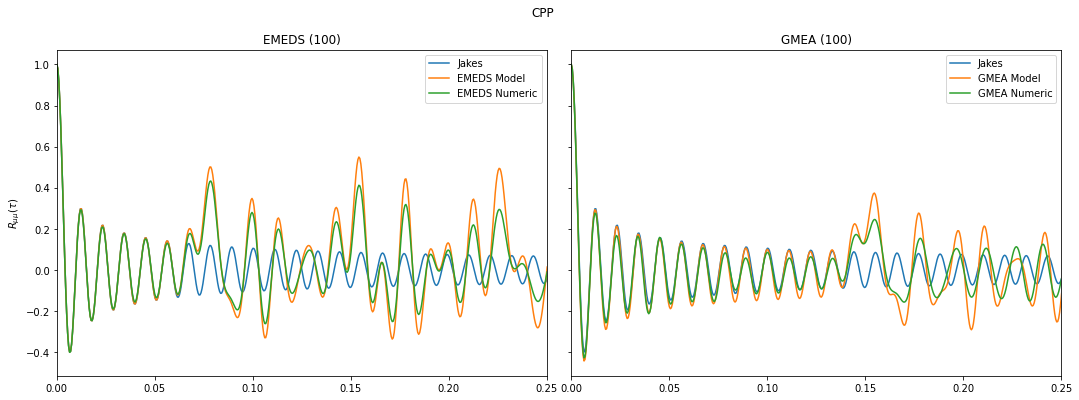

In [6]:
#    |==================| |PLOT| |=======================|
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (18, 6))
fig.suptitle('CPP')
ax1.plot(t_g, irxx, t_g, rxx_meds, t_g, rxx_meds_cpp)
ax1.set_title('EMEDS (100)')
ax1.set_ylabel(r'$R_{\mu\mu}(\tau)$')
ax1.legend(['Jakes', 'EMEDS Model', 'EMEDS Numeric'])
ax1.set_xlim(0, 0.25)
ax2.plot(t_g, irxx, t_g, rxx_gmea, t_g, rxx_gmea_cpp/rxx_gmea_cpp[0])
ax2.set_title('GMEA (100)')
ax2.legend(['Jakes', 'GMEA Model', 'GMEA Numeric'])
ax2.set_xlim(0, 0.25)
fig.subplots_adjust(wspace=0.05)
fig.show()